# Setup

In [ ]:
%pip install kornia==0.4.0
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math 
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.points import cords_to_map
import kornia as K
import time

## Mount drive

In [ ]:
your_path = ''
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'+your_path
import sys
sys.path.append(path)

## GPU

In [ ]:
print(torch.__version__)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')



1.6.0+cu101
CUDA is available!  Training on GPU ...


# DATA

## Define transformatiom

In [ ]:
from datasets.utils.transforms import ColorJitter, ToGray, GaussianBlur,ToTensor

## Dataset model

In [ ]:
from datasets.synthetic_shapes.synthetic_dataset_model import *



## Generate dataset and dataloader

In [ ]:
transform = transforms.Compose([ColorJitter(), 
                                ToGray(),
                                GaussianBlur(),
                                ToTensor()]) 

dataset = SyntheticShapes_dataset(path+'/datasets/synthetic_shapes/syn_shape_labels.csv',
                                  path+'/datasets/synthetic_shapes/synthetic_dataset/', 
                                  transform=transform, 
                                  landmark_bool=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

print(len(dataset))
print(len(dataloader))
for iter, (im,label) in enumerate(dataloader):
  print('ok')
  if iter>5:
    break


  

100000
20000
ok
ok
ok
ok
ok
ok
ok


## Test model

### plot function

In [ ]:
from utils.plot import plot_imgs


### test

iteration 0/20000 is running


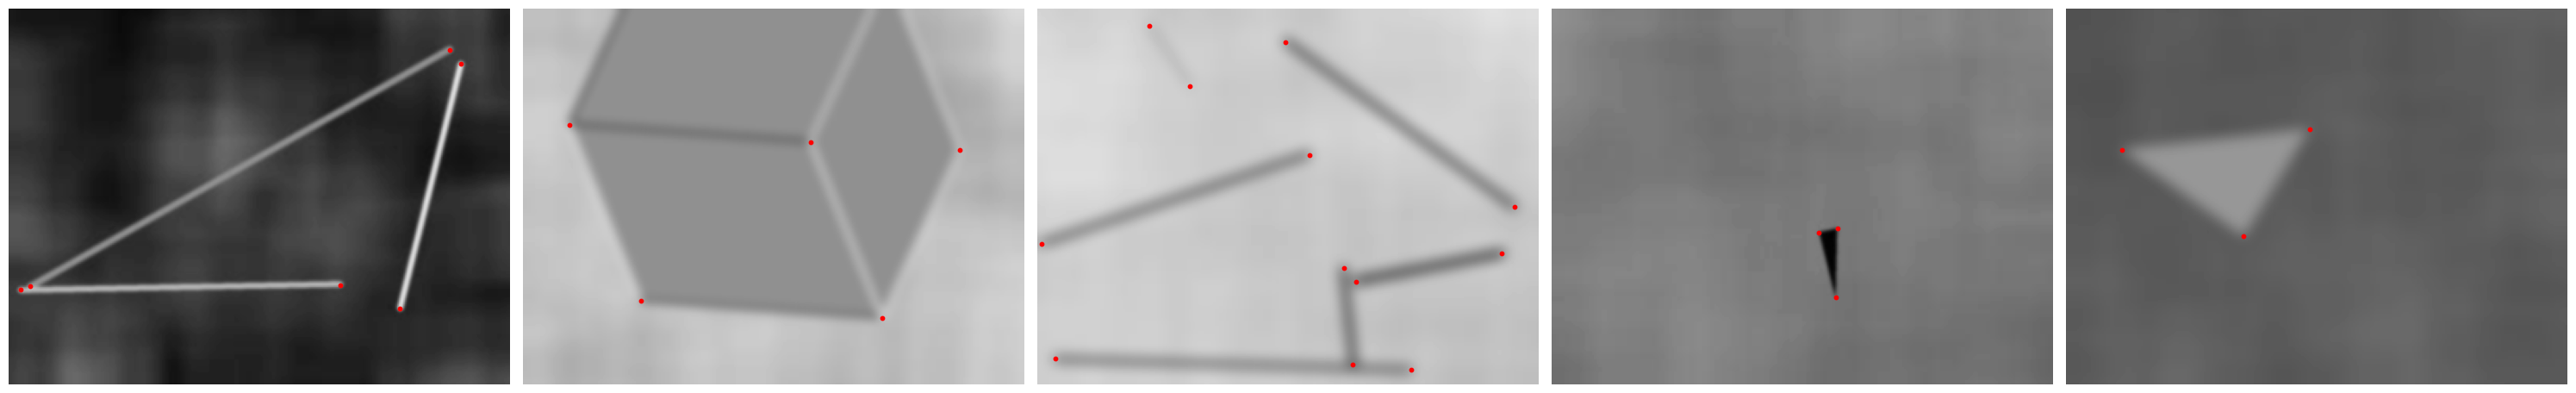

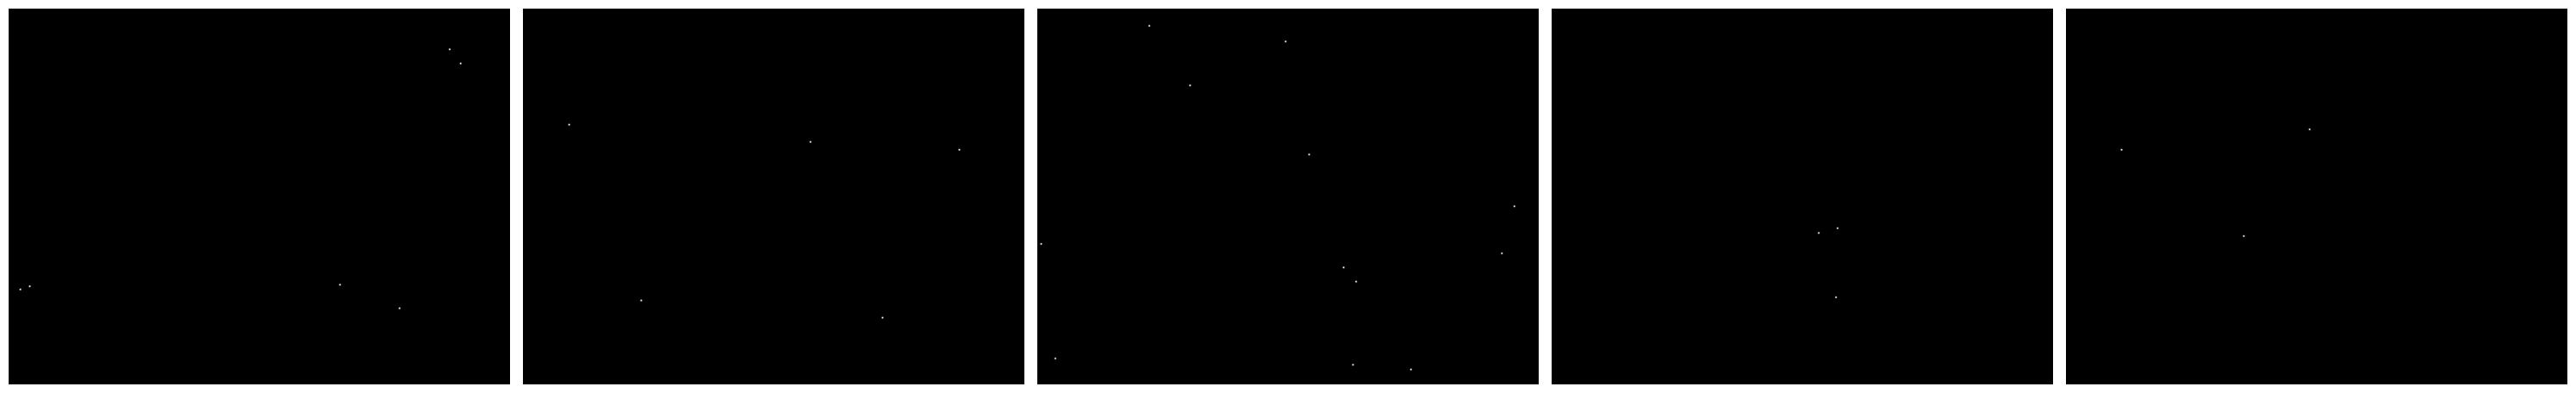

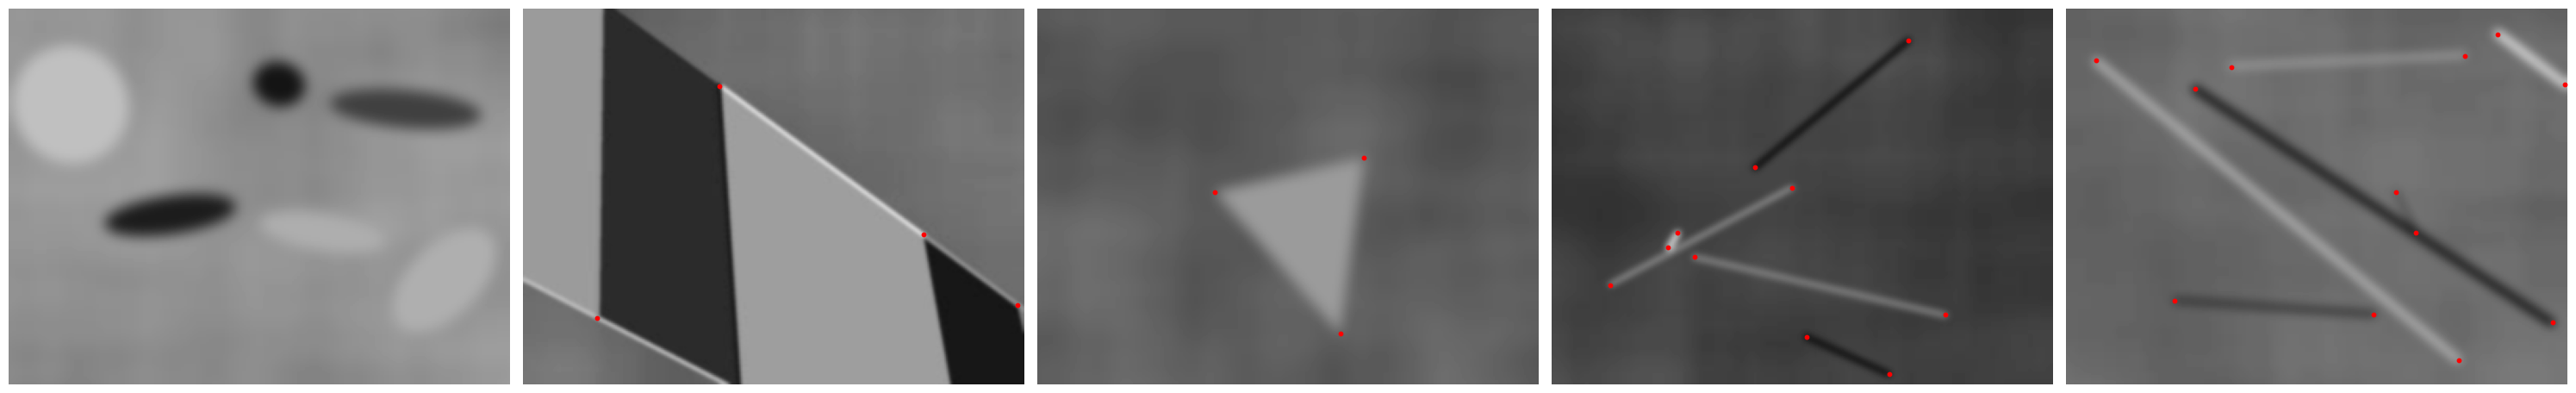

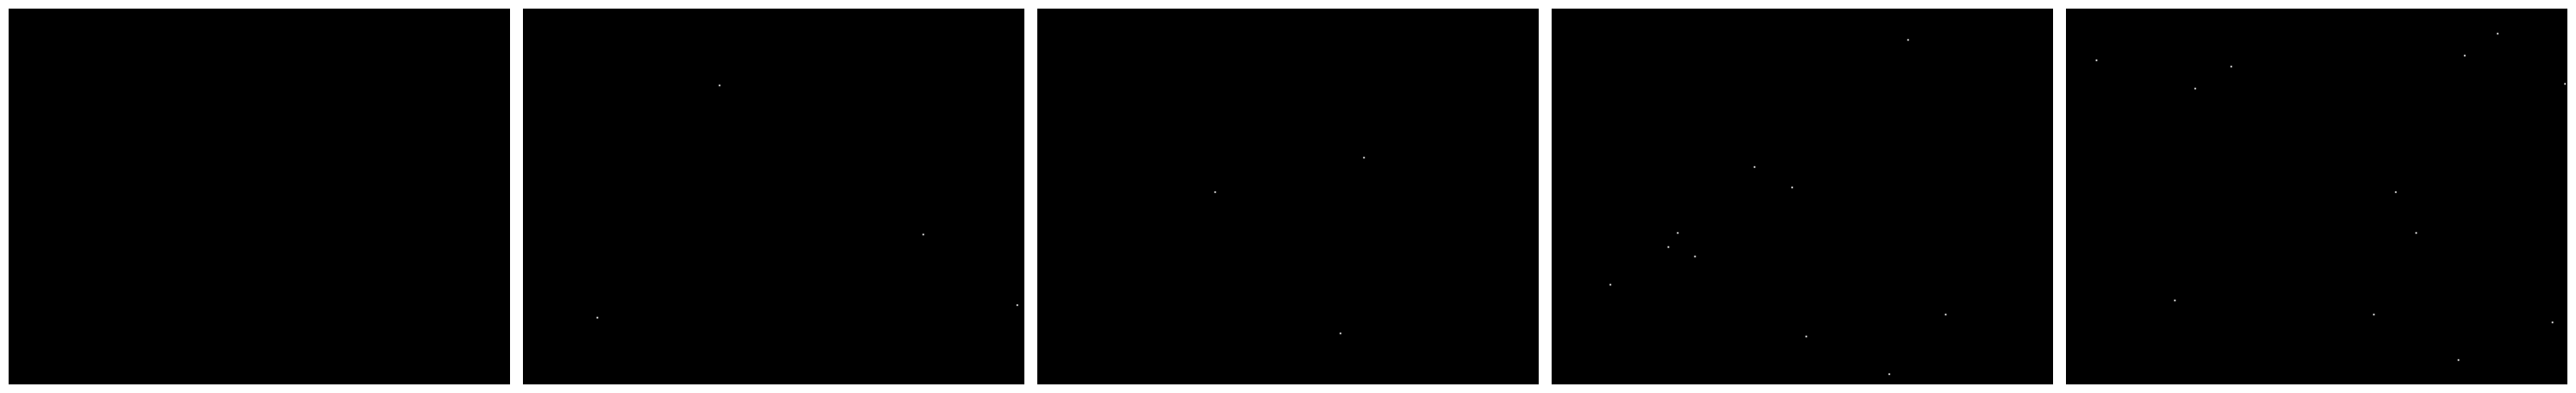

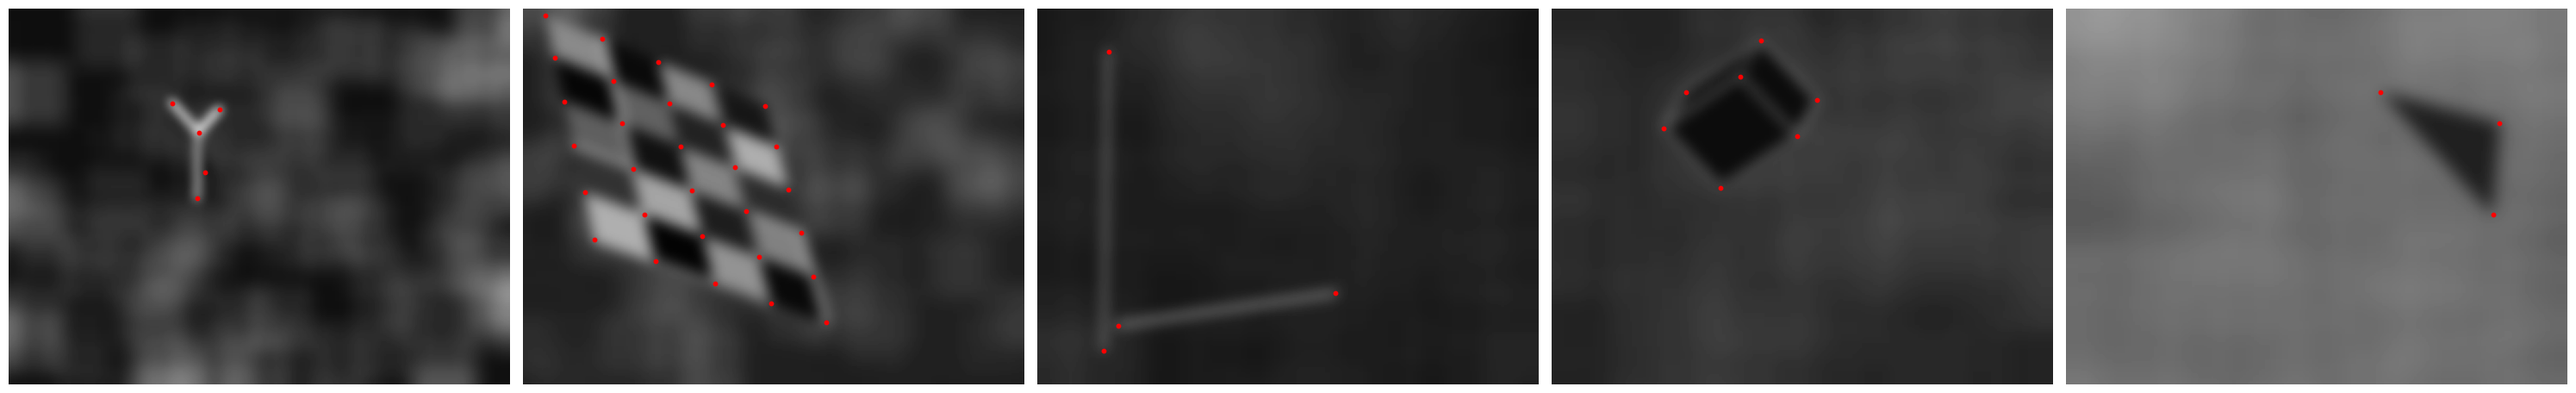

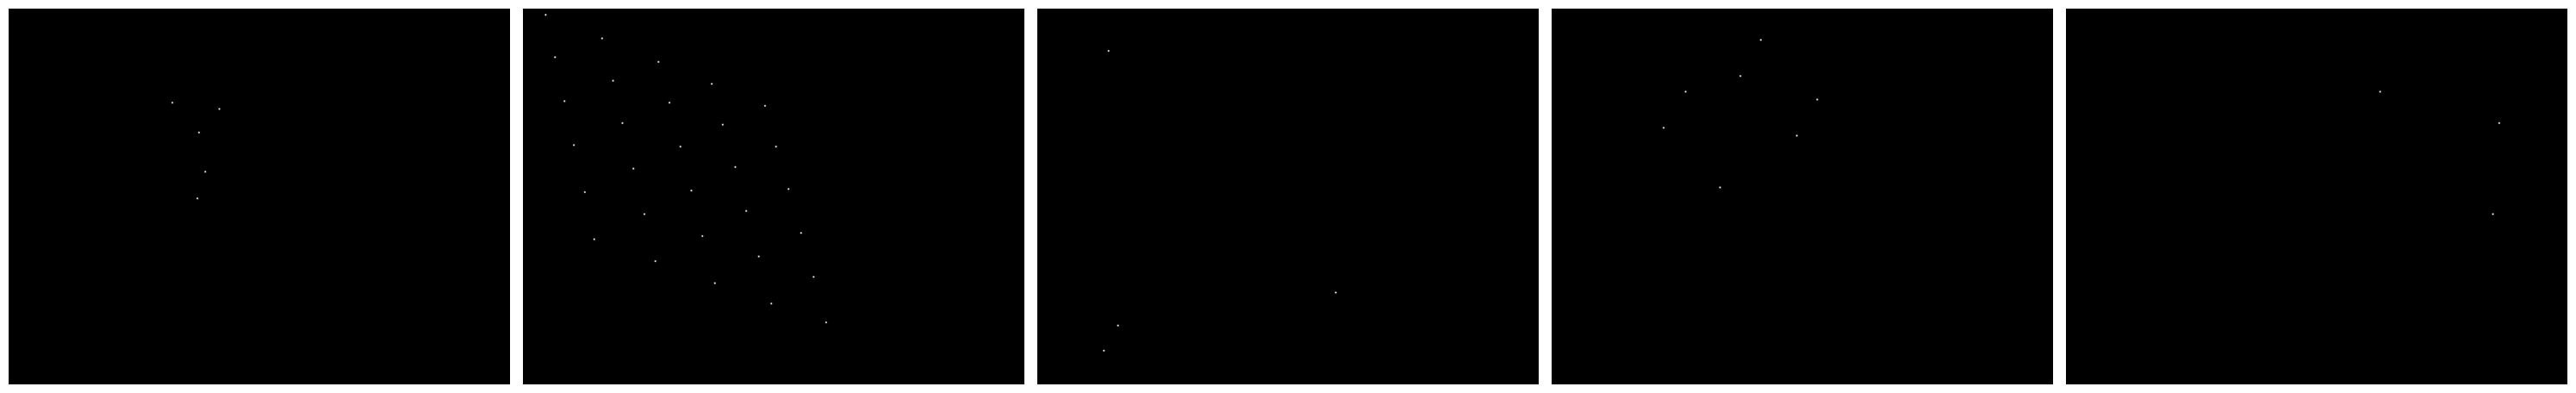

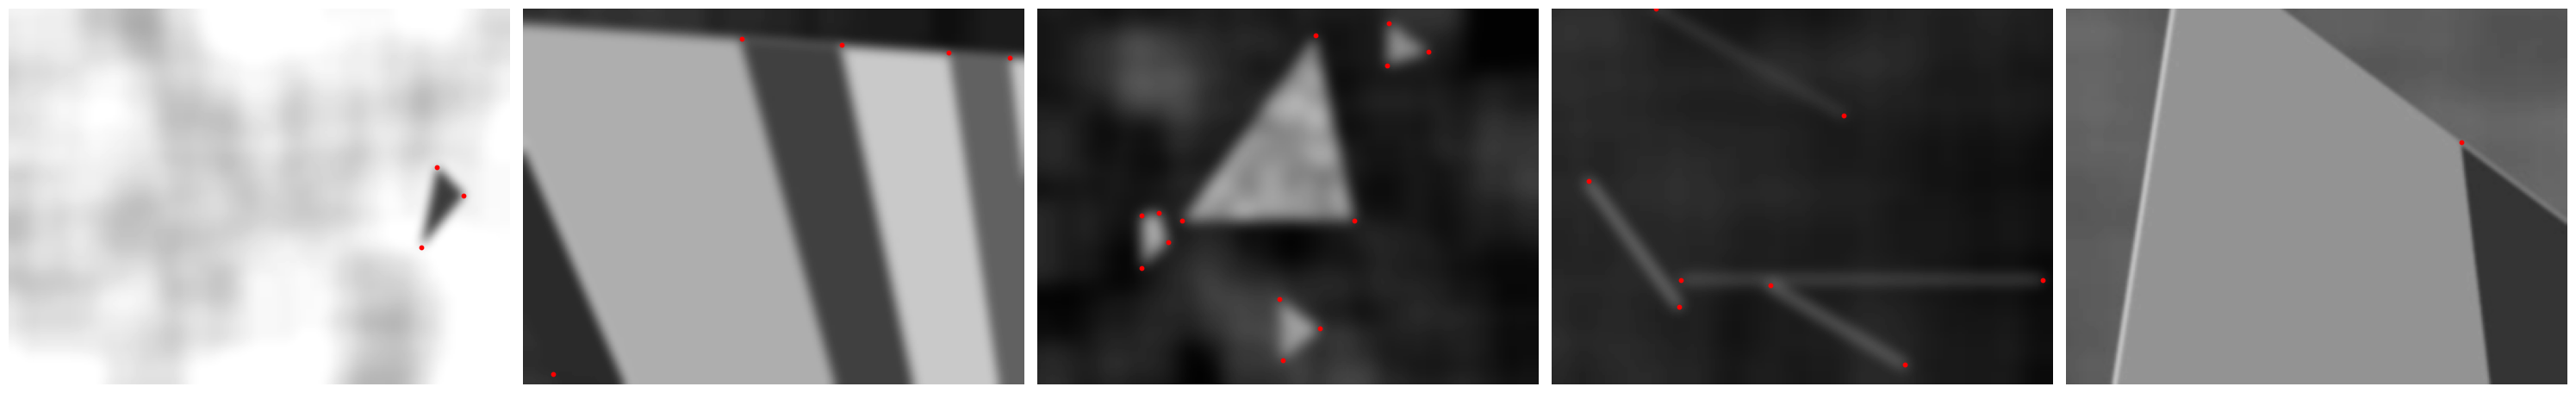

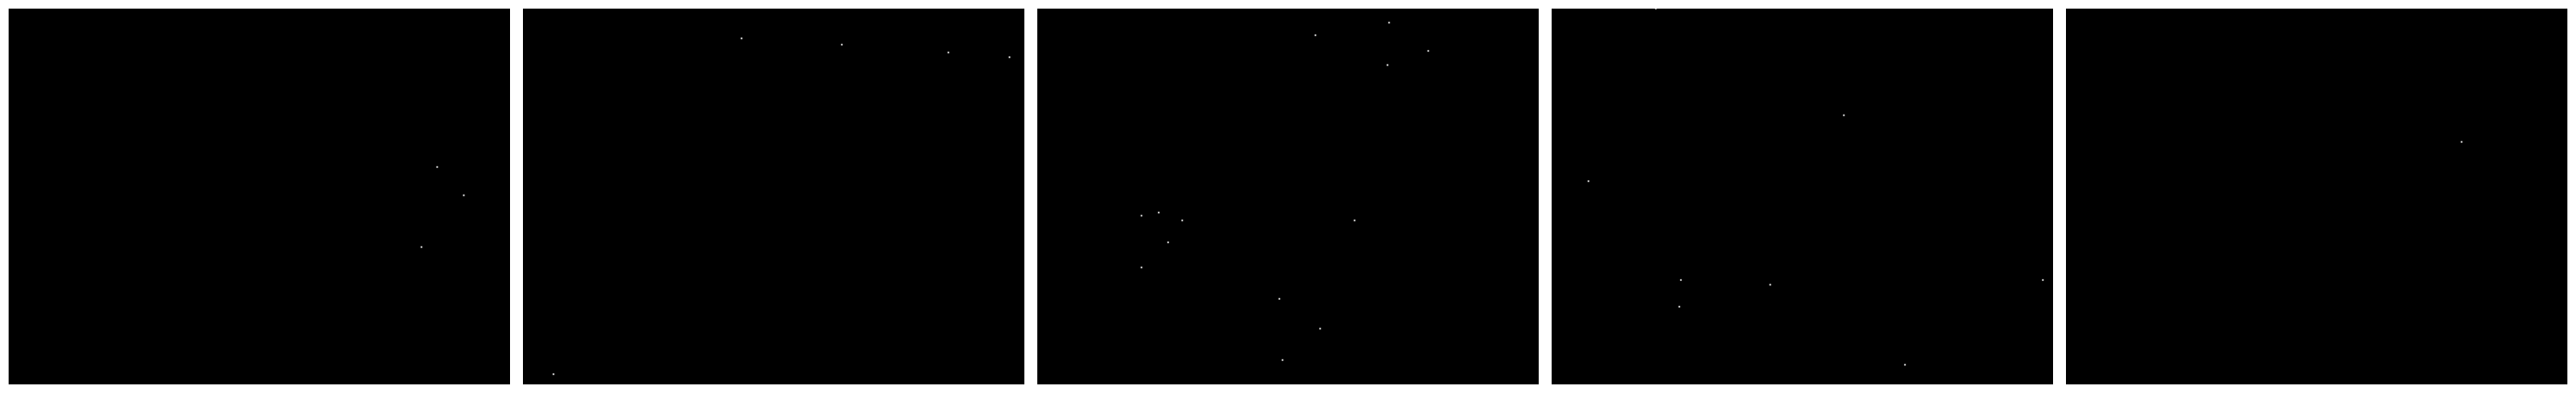

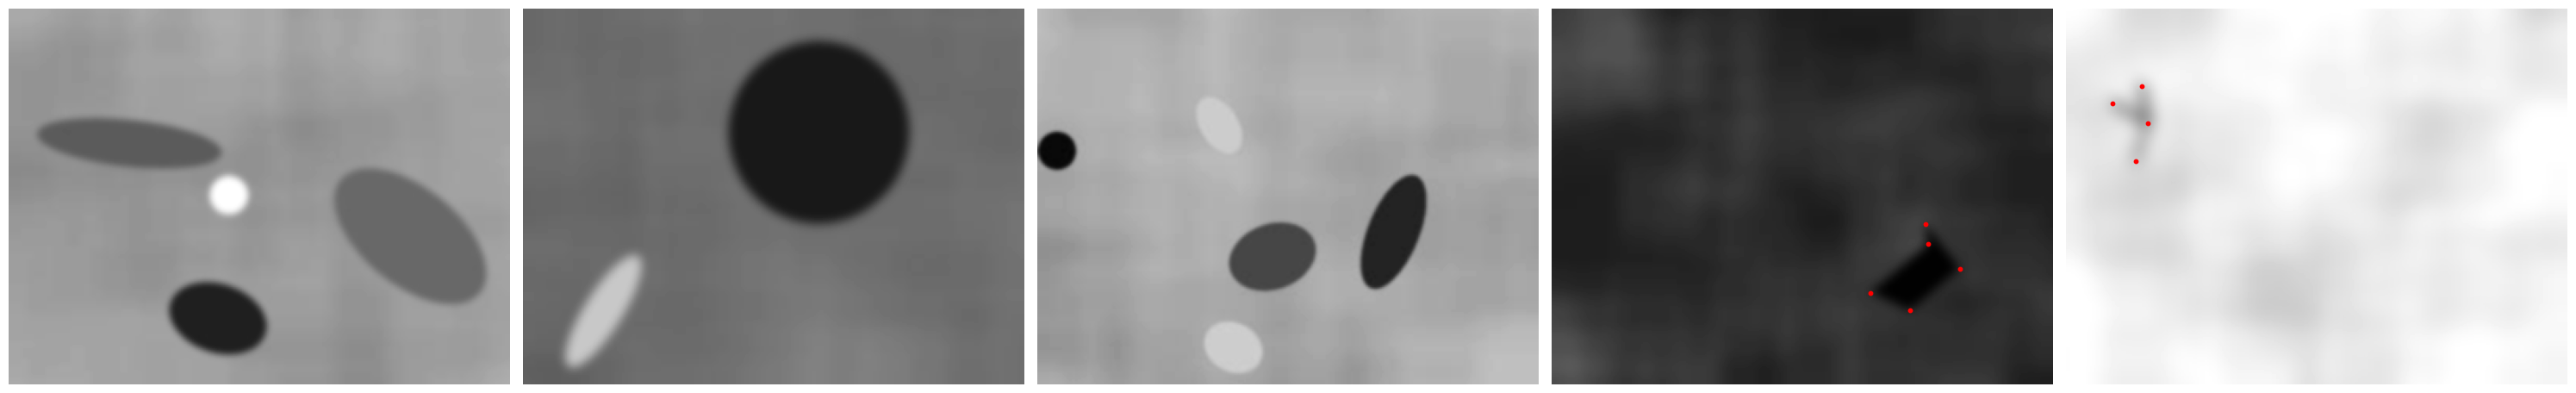

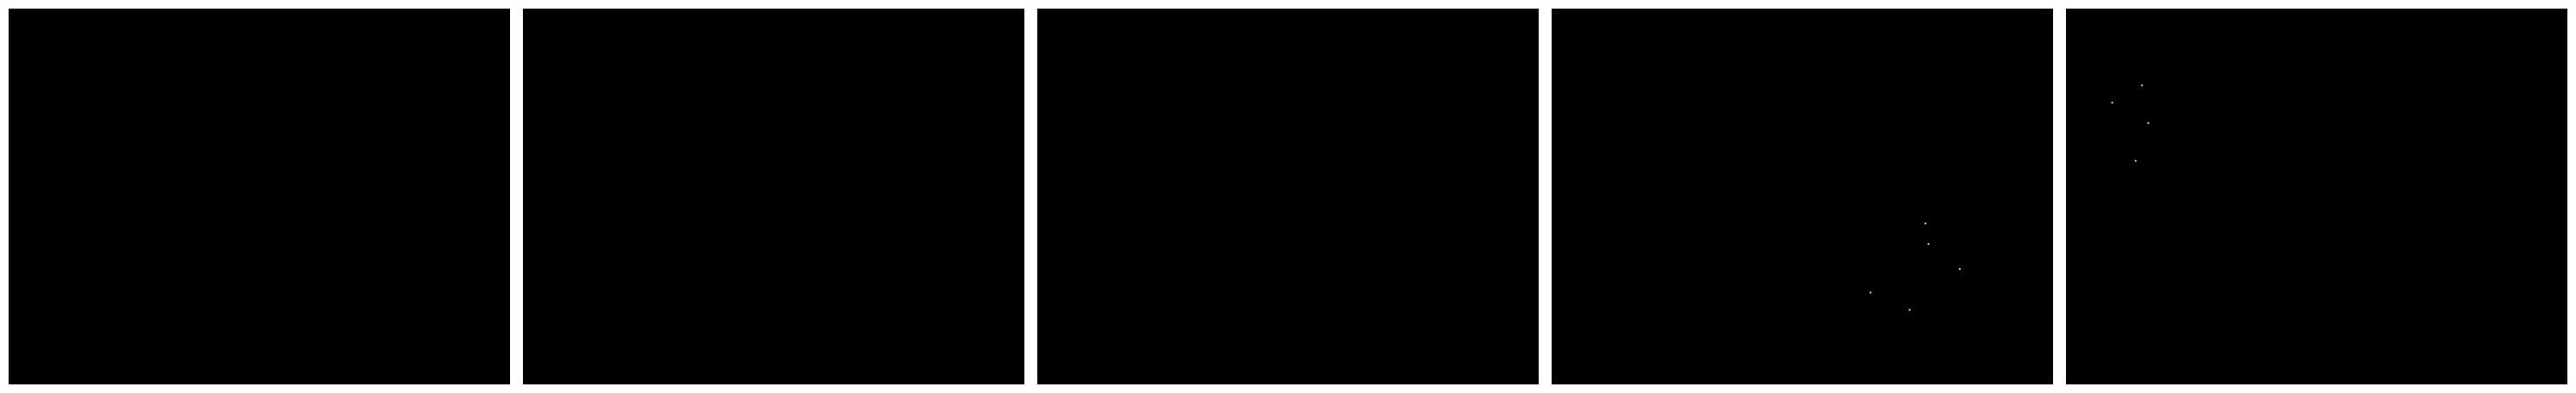

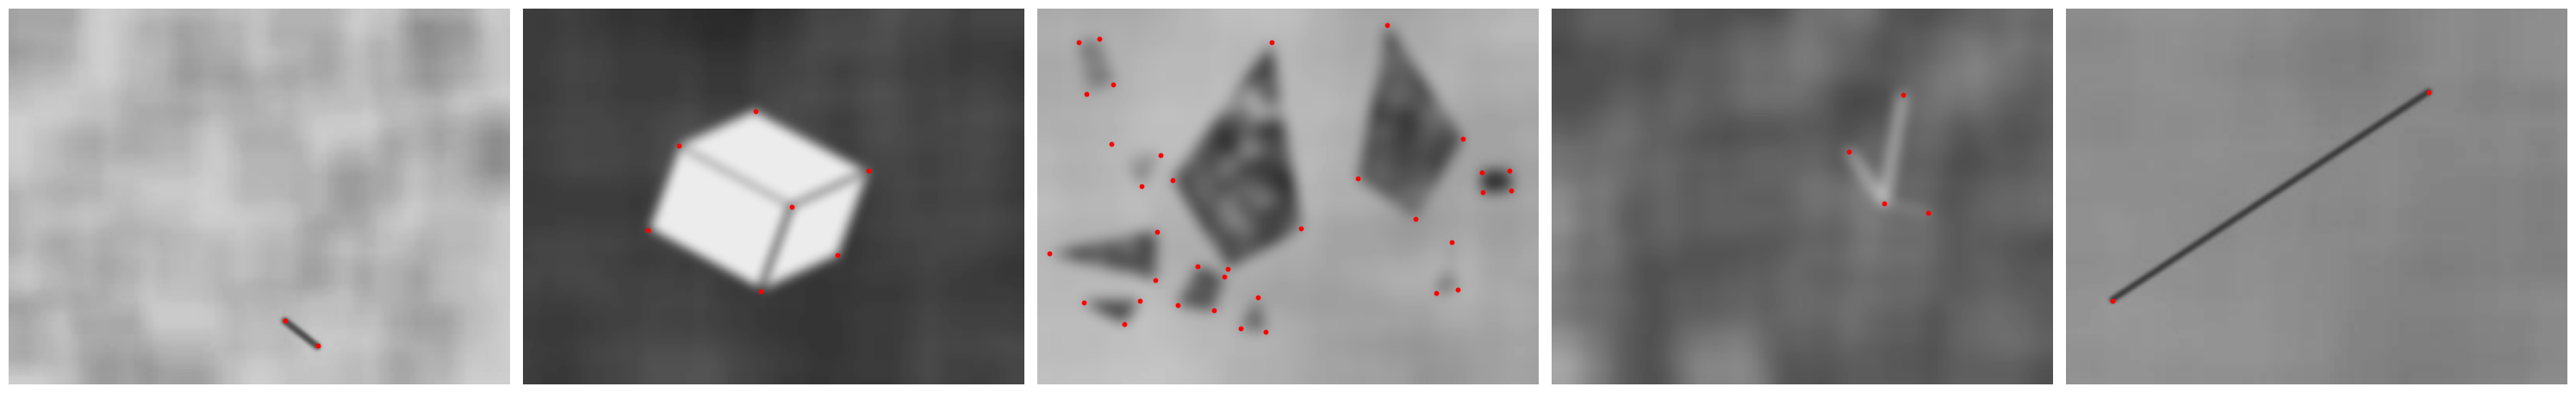

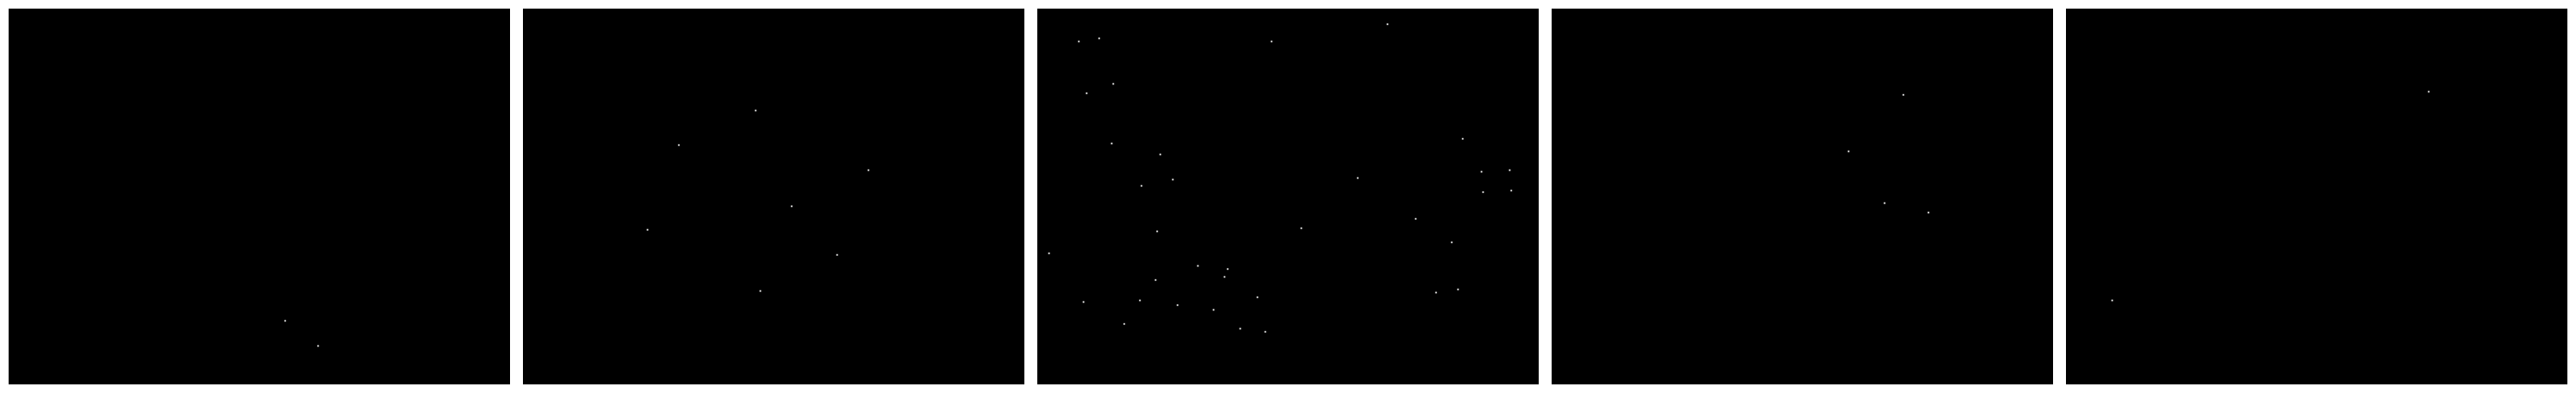

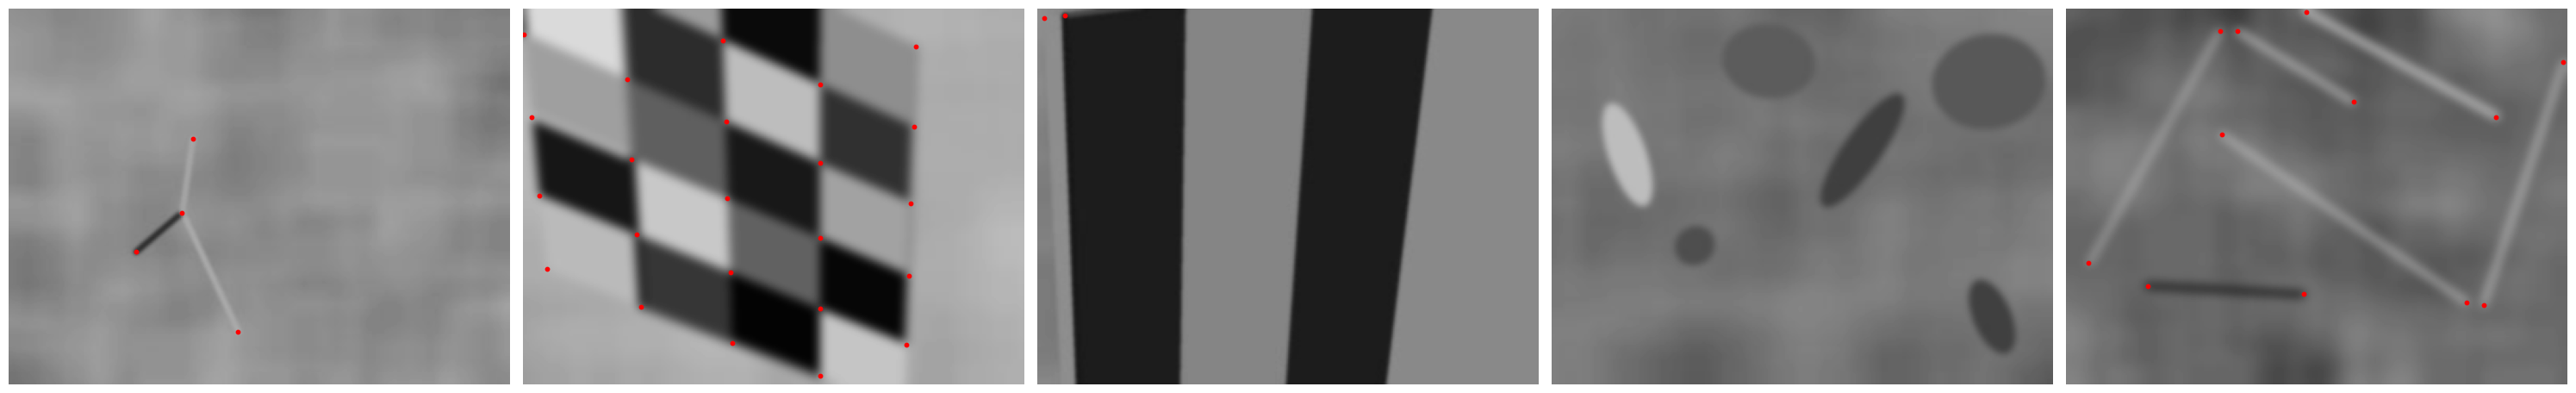

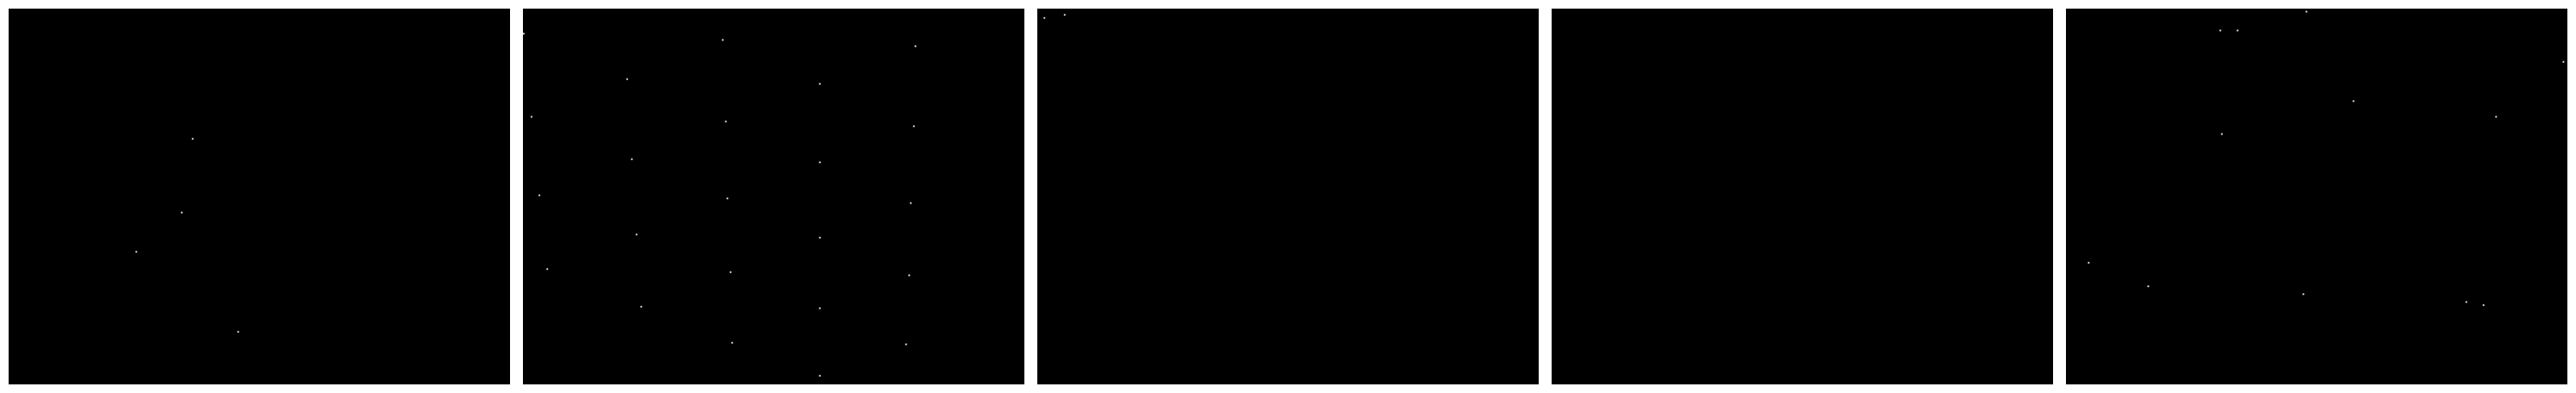

In [ ]:
for iter, (im, label) in enumerate(dataloader):
  label = label.type(torch.double)
  label = label.unsqueeze(1)
  imgs= K.tensor_to_image(im)
  size = im.size()
  map = cords_to_map(label, size, device=False)
  im_map = K.tensor_to_image(map)
  if iter%10==0:
    print('iteration {}/{} is running'.format(iter,len(dataloader)))
  plot_imgs(imgs, label=label)
  plot_imgs(im_map)
  if iter>5:
    break


# Net architecture

## Superpoint model

In [ ]:
from models.superpoint import SuperPointNet

## functions for Loss calculations

In [ ]:
from models.utils.loss import detector_loss


# Training magic point on syn' shapes

## Train function

In [ ]:
def train_synthetic_magic(dataloader,writer, net, save_path, filename, lr=0.001):
  t_0 = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  net.to(DEVICE)
  model.train()
  for e in range(20):
    for iter, (im, label) in enumerate(dataloader):
      optimizer.zero_grad()
      im = im.to(DEVICE).type(torch.float)
      label = label.to(DEVICE)
      #go through model
      chi_points, desc = net(im)
      #get map label
      label = label.type(torch.double)
      size = im.size()
      map = cords_to_map(label, size)
      map[map<0.005] = 0
      #loss
      loss = detector_loss(map, chi_points)
      loss.backward()
      optimizer.step()
      writer.add_scalar("Loss/train", loss, e*len(dataloader)+iter)
      if iter%10==0:
        print('iteration {}/{} is running'.format(e*len(dataloader)+iter,20*len(dataloader)))
        print('loss is:',loss.item())
      if iter%50==0:
        t_c = time.time()
        minute = (t_c-t_0)/60
        print('saving weights from iteration {} with loss {}, {} minutes pased'.format(e*len(dataloader)+iter,loss.item(),int(minute)))
        torch.save(model.state_dict(), save_path+filename)
  # Save weights
  torch.save(model.state_dict(), save_path+filename)
  t_f = time.time()
  hours = (t_f-t_0)/3600
  print('finished in {} hours'.format(hours))

## Run

In [ ]:
#tensorflow
from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
%load_ext tensorboard

logs_base_dir = 'logs'
os.makedirs(logs_base_dir, exist_ok=True)

log_dir_magic_synthetic_loss = "%s/magicpoint/synthetic_loss/%s" % (logs_base_dir,  datetime.now().strftime("%m%d-%H%M"))
writer_magic = SummaryWriter(log_dir_magic_synthetic_loss)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
model = SuperPointNet(superpoint_bool=False)
weights_path = path+'/weights/magic_weights.pth'
#model.load_state_dict(torch.load(weights_path,
#                               map_location=lambda storage, loc: storage))



train_synthetic_magic(dataloader, writer_magic, model,path, '/weights/magic_weights.pth')


In [ ]:
#writer_magic.flush()
%tensorboard --logdir 'logs'